# Algorithm Walk-Through

This notebook will walkthrough the preprocessing steps as well as the ML algorithm training procedure used for the multi-dimensional, multi-output data. 

## Experiment Overview

## Code

### Packages

In [183]:
import sys
sys.path.insert(0, "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/src")

# Standard packages
import numpy as np
import pandas as pd

# Datasets
from data.make_dataset import DataLoader

# Features
from features.build_features import times_2_cycles, geo_2_cartesian, get_geodataframe
from features.pca_features import transform_all, transform_individual
from sklearn.preprocessing import StandardScaler

# ML Models
from sklearn.model_selection import train_test_split
from models.baseline import train_rf_model

# Visualization
from visualization.visualize import plot_mo_stats, plot_geolocations
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### 1 Load Data

#### 1.1 Core Data

In this step, we will load the standard data. This includes the following variables:

* SLA
* PAR
* RHO WN 412
* RHO WN 443
* RHO WN 490
* RHO WN 555
* RHO WN 670
* MLD
* Lat
* Lon
* DOY

In [184]:
def load_standard_data(region: str='NA'):

    # initialize dataloader
    dataloader = DataLoader()

    # load data
    X = dataloader.load_data(region=region, drop_meta=True)

    return X

In [185]:
X_core = load_standard_data('NA')

In [186]:
X_core.shape

(3022, 11)

In [187]:
X_core.head()

,sla,PAR,RHO_WN_412,RHO_WN_443,RHO_WN_490,RHO_WN_555,RHO_WN_670,MLD,lon,lat,doy
0,5.421500,44.7510,0.026754,0.021997,0.016902,0.004928,0.000069,50,-27.221187,12.073372,1
1,5.845199,45.2395,0.025535,0.020452,0.016493,0.004793,0.000119,58,-27.042640,12.199892,6
2,0.756100,50.9293,0.007764,0.009328,0.009720,0.003551,0.000421,52,-26.491484,11.554463,36
3,0.326600,50.8669,0.007064,0.008832,0.009639,0.003629,0.000407,62,-26.471429,11.441130,41
4,0.326300,53.1347,0.020773,0.019439,0.015983,0.005122,0.000562,54,-26.447072,11.427888,46


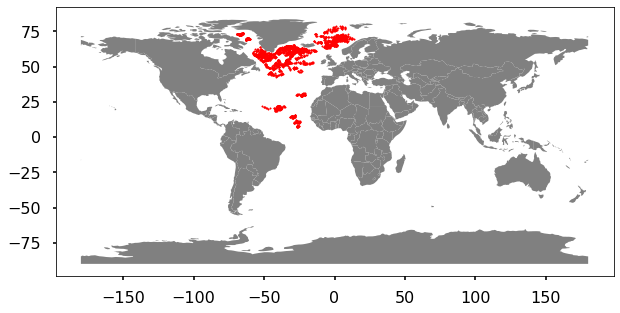

In [188]:
# convert dataframe into geopandas dataframe
core_gdf = get_geodataframe(X_core.copy())

# plot world map with points
plot_geolocations(core_gdf, save_name='na')

#### 1.2 High Dimensional Data

In this section, we will extract the high dimensional datasets. They include:

* Temperature
* Density
* Salinity
* Spiciness

In [189]:
def load_high_dim_data(region='NA'):
    
    # initialize dataloader
    dataloader = DataLoader()
    drop_meta=True

    X_temp = dataloader.load_temperature(region=region, drop_meta=drop_meta)
    X_dens = dataloader.load_density(region=region, drop_meta=drop_meta)
    X_sal = dataloader.load_salinity(region=region, drop_meta=drop_meta)
    X_spicy = dataloader.load_spicy(region=region, drop_meta=drop_meta)
    
    return X_temp, X_dens, X_sal, X_spicy

In [190]:
X_temp, X_dens, X_sal, X_spicy = load_high_dim_data('NA')

# add prefix
X_temp = X_temp.add_prefix('temp_')
X_dens = X_dens.add_prefix('dens_')
X_sal = X_sal.add_prefix('sal_')
X_spicy = X_spicy.add_prefix('spice_')

#### 1.3 - Multi-Output Data

We load the multioutput regression labels.

In [191]:
def load_labels(region='NA'):
    # initialize dataloader
    dataloader = DataLoader()
    drop_meta=True
    
    return dataloader.load_ouputs(region=region, drop_meta=drop_meta)

In [192]:
y = load_labels('NA')

---
### 2. Preprocessing

#### 2.1 - Coordinate Transformation

In this step, we will do a simple coordinate transformation of the lat,lon variables from geospatial to cartesian coordinates. This will increase the dimensionality of our dataset from 11 dimensions to 12 dimensions.

In [193]:
X_core = geo_2_cartesian(X_core)

X_core[['x', 'y', 'z']].describe()

,x,y,z
count,3022.000000,3022.000000,3022.000000
mean,0.424498,-0.278527,0.803373
std,0.166646,0.175314,0.195811
min,0.102689,-0.723914,0.121478
25%,0.333212,-0.409115,0.806248
50%,0.396892,-0.284740,0.869006
75%,0.475388,-0.174620,0.905730
max,0.896169,0.080525,0.980676


#### 2.2 - Time Transformation

In this step, we will transform the `doy` coordinates to cycles of sines and cosines. This will increase the dimensionality of our data from from 12 to 13.

In [194]:
X_core = times_2_cycles(X_core, ['doy'])

X_core[['doy_cos', 'doy_sin']].describe()

,doy_cos,doy_sin
count,3022.000000,3022.000000
mean,-0.450884,0.158825
std,0.536955,0.695279
min,-0.999963,-0.999991
25%,-0.882048,-0.530730
50%,-0.618671,0.313107
75%,-0.200891,0.826354
max,1.000000,0.999991


In [195]:
core_columns = X_core.columns

In [196]:
core_columns

Index(['sla', 'PAR', 'RHO_WN_412', 'RHO_WN_443', 'RHO_WN_490', 'RHO_WN_555',
       'RHO_WN_670', 'MLD', 'x', 'y', 'z', 'doy_sin', 'doy_cos'],
      dtype='object')

#### 2.3 - Output Log Transformation

The distribution of the outputs are skewed because there is a lot more variability in the upper depths than the lower depths. Because the distribution of the outputs are fairly skewed, we propose to do a log transformation to make them normally distributed.

In [197]:
y_log = np.log(y)

y_log.describe()

,X1,X3,X5,X7,X9,X11,X13,X15,X17,X19,...,X955,X960,X965,X970,X975,X980,X985,X990,X995,X1000
count,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,...,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000
mean,-6.610019,-6.604541,-6.598069,-6.588615,-6.578833,-6.570708,-6.564953,-6.560964,-6.559300,-6.560529,...,-8.233790,-8.232517,-8.230565,-8.228788,-8.224080,-8.227809,-8.235910,-8.250272,-8.258900,-8.267904
std,0.774408,0.780557,0.788205,0.793829,0.794846,0.798021,0.798245,0.797818,0.797393,0.793843,...,0.376047,0.378086,0.379638,0.376723,0.378766,0.389448,0.392392,0.397019,0.404492,0.401916
min,-8.821682,-8.740337,-8.804875,-8.740337,-8.622554,-8.679712,-8.679712,-8.679712,-8.622554,-8.622554,...,-10.260163,-10.312530,-10.596643,-10.240126,-10.438404,-11.512925,-10.126631,-10.126631,-10.414313,-10.414313
25%,-7.264430,-7.277614,-7.278819,-7.277014,-7.264430,-7.264430,-7.272168,-7.268560,-7.278819,-7.278819,...,-8.468403,-8.468403,-8.468403,-8.468403,-8.468403,-8.468403,-8.499696,-8.517193,-8.517193,-8.517193
50%,-6.547248,-6.536192,-6.535683,-6.515713,-6.503603,-6.489045,-6.477599,-6.469500,-6.469500,-6.463711,...,-8.254829,-8.254829,-8.254829,-8.254829,-8.254829,-8.254829,-8.272543,-8.294050,-8.294050,-8.294050
75%,-5.982753,-5.976577,-5.963849,-5.948922,-5.936976,-5.928780,-5.925677,-5.921939,-5.920283,-5.920160,...,-7.929407,-7.929407,-7.928623,-7.925415,-7.915873,-7.902079,-7.907938,-7.929407,-7.929407,-7.943206
max,-4.454167,-4.416204,-4.247321,-4.203044,-4.287444,-4.220588,-4.220588,-4.224308,-4.246622,-4.323003,...,-6.927958,-6.927958,-6.927958,-6.858965,-6.927958,-6.529319,-6.838537,-6.843842,-6.431521,-6.843842


---
### 3 - Train,Test Split

We split the data into 80% training and 20% training.

**Note**: because the dataset we are dealing with is only ~3,000 data points, we will do some bootstrap techniques in the full experiment to see how well we do with different subsamples of data.

In [198]:
from typing import List, Tuple

def split_data(
    Xs: List[np.ndarray], y: np.ndarray, train_size: float=0.8, split_seed: int=123
)-> Tuple[List[np.ndarray], List[np.ndarray], np.ndarray, np.ndarray]:
    """Splits the data according to a list of inputs. 
    
    Parameters
    ----------
    Xs : List[np.ndarray, pd.DataFrame]
        The list of numpy arrays or pandas dataframes for the 
        training data.
    
    y : np.ndarray, pd.DataFrame
        The numpy arrays or pandas dataframe for the testing data.
    
    train_size : float,
        the train size (decimal or percentage)
    
    seed : int
        the seed used for the splitting
        
    Returns
    -------
    Xtr : List[np.ndarray, pd.DataFrame]
        The list of numpy arrays or pandas dataframes for the 
        split training data.
        
    Xte : np.ndarray, pd.DataFrame
        The list of numpy arrays or pandas dataframes for the 
        split testing data.
        
    
    """
    split_inputs = Xs + [y]
    dat = \
        train_test_split(
        *Xs, y,
        train_size=0.8, random_state=split_seed
    )
    
    # Split from inputs and outputs
    X = dat[:-2]
    y = dat[-2:]
    
    # Split training and test
    Xtr = X[::2]
    Xte = X[1::2]
    ytr = y[0]
    yte = y[1]
    return Xtr, Xte, ytr, yte

In [18]:
Xtr, Xte, ytr, yte = split_data(
    [X_core, X_temp, X_dens, X_sal, X_spicy],
    y_log,
    train_size=0.8, 
    split_seed=123
)

In [199]:
Xdf = pd.concat([X_core, X_temp, X_dens, X_sal, X_spicy], axis=1)

Xtr, Xte, ytr, yte =  train_test_split(
        Xdf, y_log,
        train_size=0.8, random_state=123
    )

---
### 4 - Post-Split Transformations



1. PCA Transform High Dimensional Variables

In this step, we do a PCA transformation on the concatenation for the high dimensional variables `temp`, `sal`, `dens`, and `spicy`. We will reduce the dimensionality to about 10 features.

2. Normalize Core Variables

We will use a standard scaler to make the core variables with a mean of 0 and standard deviation of 1. The ML algorithms tend to perform better with this type of standardization.

In [200]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

In [137]:
def get_new

In [139]:
len(new_names)

93

In [201]:
# define columns
temp_columns = X_temp.columns.values
dens_columns = X_dens.columns.values
sal_columns = X_sal.columns.values
spicy_columns = X_spicy.columns.values
core_columns = ['sla', "PAR","RHO_WN_412","RHO_WN_443","RHO_WN_490","RHO_WN_555","RHO_WN_670","MLD"]
loc_columns = ['x', 'y', 'z', "doy_cos", "doy_sin"]

n_components = 5

new_columns = [
    *[f"temperature_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"density_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"salinity_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"spicy_pc{icomponent+1}" for icomponent in range(n_components)],
    *core_columns, *loc_columns
]
seed = 123
# define transfomer
X_transformer = ColumnTransformer(
    [
        ('temp', PCA(n_components=n_components, random_state=seed), temp_columns),
        ('dens', PCA(n_components=n_components, random_state=seed), dens_columns),
        ('sal', PCA(n_components=n_components, random_state=seed), sal_columns),
        ('spice', PCA(n_components=n_components, random_state=seed), spicy_columns),
        ('core', StandardScaler(with_mean=True, with_std=True), core_columns)
    ],
    remainder='passthrough'
)
# fit transform to data
X_transformer.fit(Xtr)

# transform data
Xtrain = X_transformer.transform(Xtr)
Xtest = X_transformer.transform(Xte)

#### 4.3 - Normalize Outputs

We will use the same standardization as shown above.

In [202]:
output_transformer = StandardScaler(with_mean=True, with_std=False)

ytrain = output_transformer.fit_transform(ytr)
ytest = output_transformer.transform(yte)

---
### 5 - Train ML Model

In this section, we will use a standard random forest (RF) regressor to train on our dataset. Because our data is multi-output, we will need 1 RF per output layer.

In [205]:
rf_model = train_rf_model(Xtrain, ytrain, verbose=0)

---
### 6 - Test ML Model

#### 6.1 - Training Data Results

This is often not reported but it is very good to check how well a model does on the initial training data because we have no entered a validation set. If we find that the training stats are too high and the testing stats are very low then we know that we're either overfitting and/or our model is not generalizing very well.

In [206]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_stats(y_pred: np.ndarray, y: np.ndarray, each_level: bool=False):
    
    stats = pd.DataFrame()
    
    # Get total average statistics
    if each_level == False:
        multioutput = 'uniform_average'
        mae = mean_absolute_error(y, ypred, multioutput=multioutput)
        mse = mean_squared_error(y, ypred, multioutput=multioutput)
        rmse = mse
        r2 = r2_score(y, ypred, multioutput=multioutput)
        stats = pd.DataFrame(data=[[mae, mse, rmse, r2]], columns=['mae', 'mse', 'rmse', 'r2'])
    elif each_level == True:
        multioutput = 'raw_values'
        stats['mae'] = mean_absolute_error(y, ypred, multioutput=multioutput)
        stats['mse'] = mean_squared_error(y, ypred, multioutput=multioutput)
        stats['rmse'] = np.sqrt(stats['mse'])
        stats['r2'] = r2_score(y, ypred, multioutput=multioutput)
    else:
        raise ValueError(f"Unrecognized stat request: {each_level}")
    
    return stats

First we will look at the statistics on average to see what we get.

In [207]:
ypred = rf_model.predict(Xtrain)

In [208]:
# each level
each_level = False

stats = get_stats(ypred, ytrain, each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.051121,0.006006,0.006006,0.964117


Then we can look at the statistics for each level.

In [209]:
each_level = True

stats_df = get_stats(ypred, ytrain, each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.091324,0.016494,0.128428,0.972875
1,0.090013,0.016097,0.126876,0.973959
2,0.090002,0.016428,0.128173,0.973945
3,0.090716,0.016511,0.128495,0.974206
4,0.090571,0.016731,0.129348,0.973879


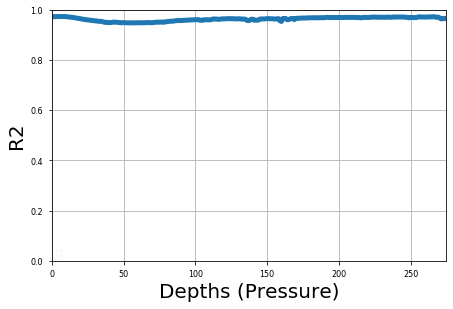

In [210]:
statistic = 'r2'

plt.style.use('seaborn-paper')
plot_mo_stats(
    stats_df, 
    stat=statistic, 
    save_name=None
)

#### 6.2 - Testing Data Results

In [211]:
ypred = rf_model.predict(Xtest)

In [212]:
# each level
each_level = False

stats = get_stats(ypred, ytest, each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.139513,0.04336,0.04336,0.738922


In [213]:
each_level = True

stats_df = get_stats(ypred, ytest, each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.259621,0.128811,0.358903,0.770074
1,0.254193,0.126312,0.355404,0.777285
2,0.259052,0.130916,0.361823,0.773256
3,0.257108,0.129238,0.359497,0.778578
4,0.258315,0.131854,0.363117,0.776324


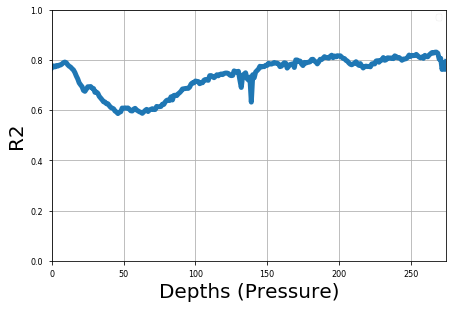

In [214]:
statistic = 'r2'
plt.style.use('seaborn-paper')
plot_mo_stats(
    stats_df, 
    stat='r2', 
    save_name=None
)


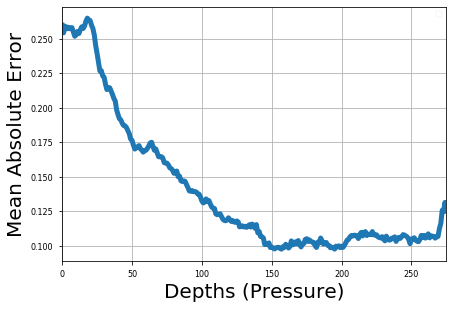

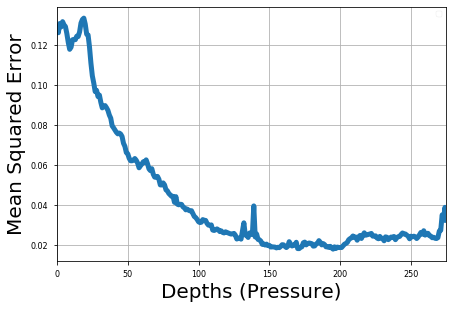

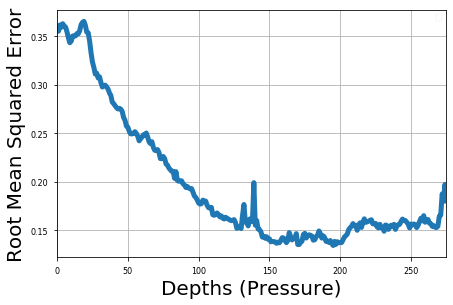

In [215]:
plot_mo_stats(stats_df, stat='mae', save_name=None)
plot_mo_stats(stats_df, stat='mse', save_name=None)
plot_mo_stats(stats_df, stat='rmse', save_name=None)

---
### 7 - Post Analysis

#### 7.1 - Feature Importance

For some algorithms, we can calculate the feature importance based on the inputs dimensions. This is true for the random forest model.

In [177]:
tree_feature_importances = \
    rf_model.feature_importances_

feature_names = np.asarray(new_columns) #np.concatenate((core_columns.values, np.array(pca_columns)))

assert feature_names.shape[0] == tree_feature_importances.shape[0], "Shapes don't match"

sorted_idx = tree_feature_importances.argsort()

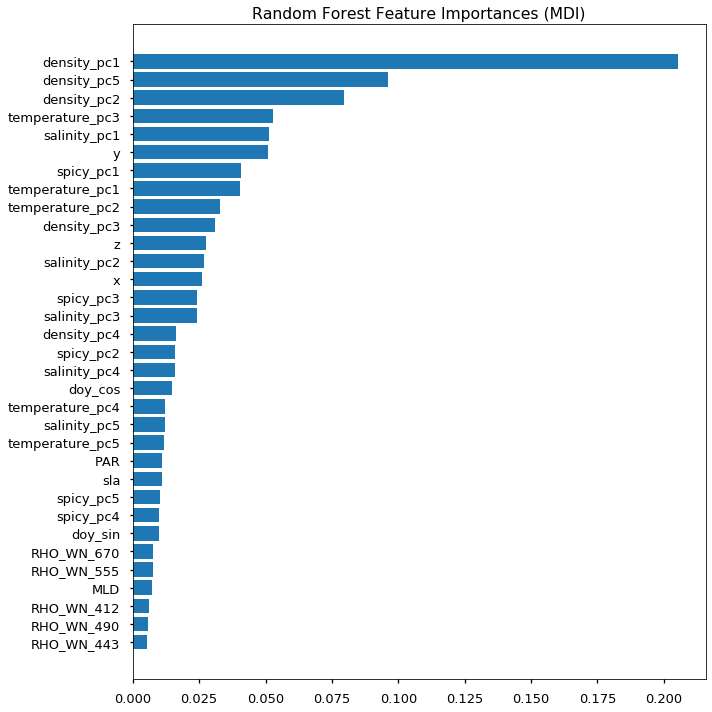

In [181]:
y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

#### 7.2 - Permutation Plot

In [179]:
perm_result_test = permutation_importance(
    rf_model, 
    Xtest, 
    ytest, 
    n_repeats=10,
    random_state=42, 
    n_jobs=1
)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:    0.7s finished
/home/emmanuel/.conda/envs/ml4ocn/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", Futu

In [36]:
sorted_idx = perm_result_test.importances_mean.argsort()

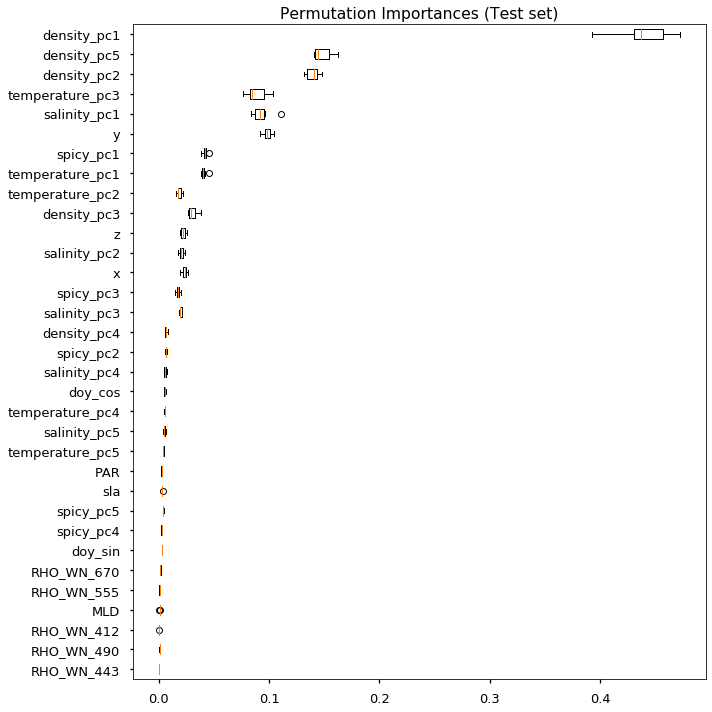

In [182]:
fig, ax = plt.subplots(figsize=(10,10))
plt.style.use(['seaborn-talk'])
ax.boxplot(
    perm_result_test.importances[sorted_idx].T,
    vert=False, 
    labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (Test set)")
fig.tight_layout()
plt.show()

In [38]:
perm_result_train = permutation_importance(
    rf_model, 
    Xtrain, 
    ytrain, 
    n_repeats=10,
    random_state=42, 
    n_jobs=1
)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:    2.3s finished
/home/emmanuel/.conda/envs/ml4ocn/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", Futu

KeyboardInterrupt: 

In [ ]:
sorted_idx = perm_result_train.importances_mean.argsort()

In [ ]:
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots()
ax.boxplot(
    perm_result_train.importances[sorted_idx].T,
    vert=False, 
    labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (Train set)")
fig.tight_layout()
plt.show()